# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [4]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/ltt_3780_b--7301/  (uses cloutier)
# cloutier 2020: https://iopscience.iop.org/article/10.3847/1538-3881/ab91c2
# nowak 2020: https://www.aanda.org/articles/aa/full_html/2020/10/aa37867-20/aa37867-20.html

t0_pub = [ufloat(1543.9115+57000, 0.0011), ufloat(1546.8484+57000,0.0014)]
period_pub = [ufloat(0.7683881, 0.000084), ufloat(12.2519, 0.003) ] # days
t0s = [1543.9115+57000, 1546.8484+57000]
t0_errs = [0.0011, 0.0014]
periods = [0.7683881, 12.2519]
period_errs = [0.000084, 0.003]
Ks_pub = [3.41, 4.44]
Ks_err = [0.63, 0.82]
Ms_pub = [2.62, 8.6]

depth_pub = [ufloat(1.087, 0.1), ufloat(3.24, 0.41)] # ppt
radius_pub = [ufloat(1.332, 0.075), ufloat(2.30, 0.16)] # R_earth


stteff_pub = ufloat(3360, 51)
strad_pub = ufloat(0.374, 0.011)
stmass_pub = ufloat(0.401, 0.012)

# RV reading

In [5]:
lbl_toi732 = pd.read_table('./lbl_toi732_toi732/lbl_TOI732_TOI732.rdb', sep=None, engine='python', header=0)
lbl_gl846 = pd.read_table('./lbl_toi732_gl846/lbl_TOI732_GL846.rdb', sep=None, engine='python', header=0)

names = ['lbl_toi732', 'lbl_gl846']
planets = ['b', 'c']
star_name = 'toi732'

In [6]:
print(len(lbl_toi732), len(lbl_gl846))

44 44


In [7]:
datasets = list([lbl_toi732, lbl_gl846])

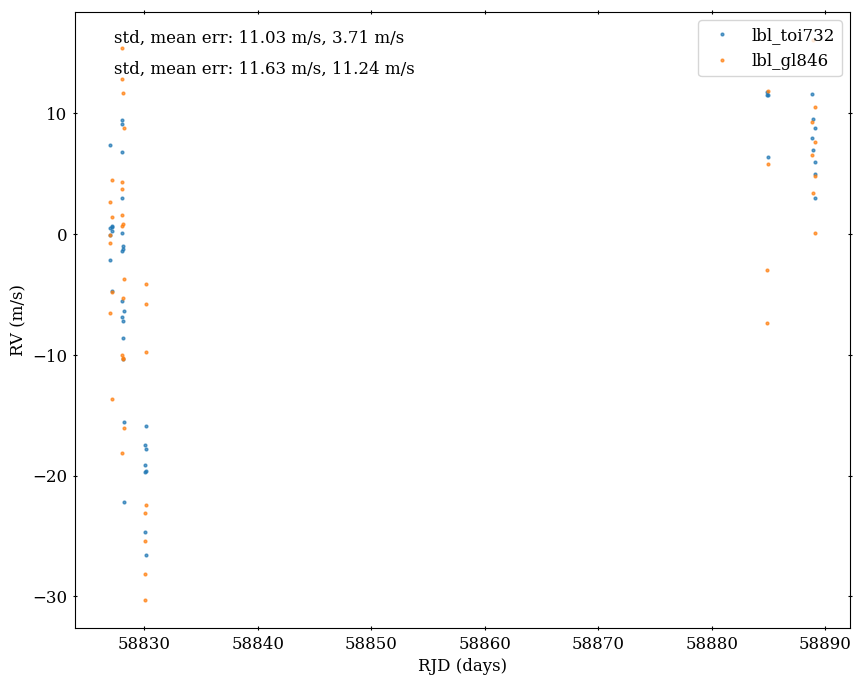

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [9]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(44, 172)
(44, 172)


In [10]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[0, 0]


In [11]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

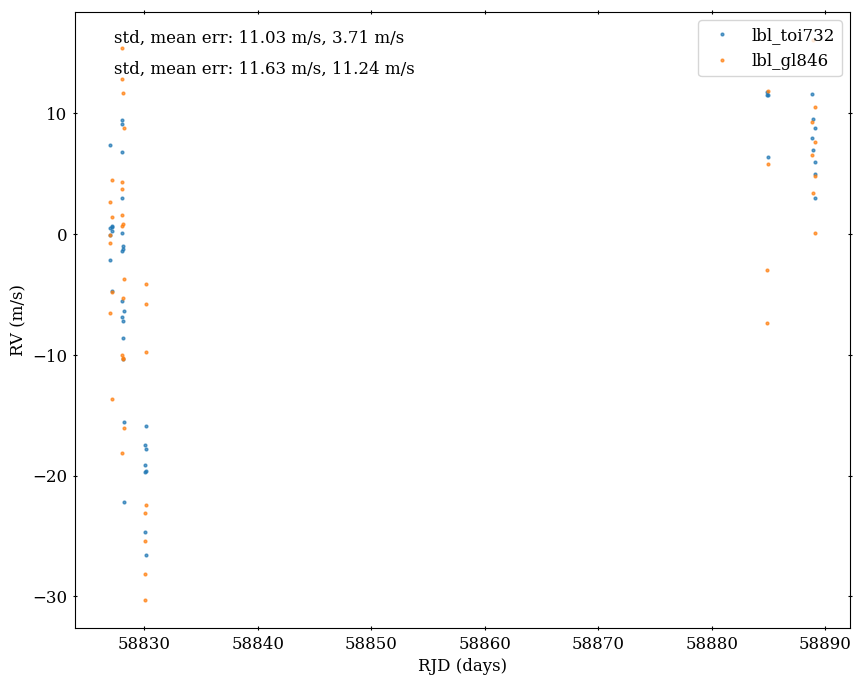

In [12]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [13]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01]
    faps[k] = ls[k].false_alarm_level(probabilities)

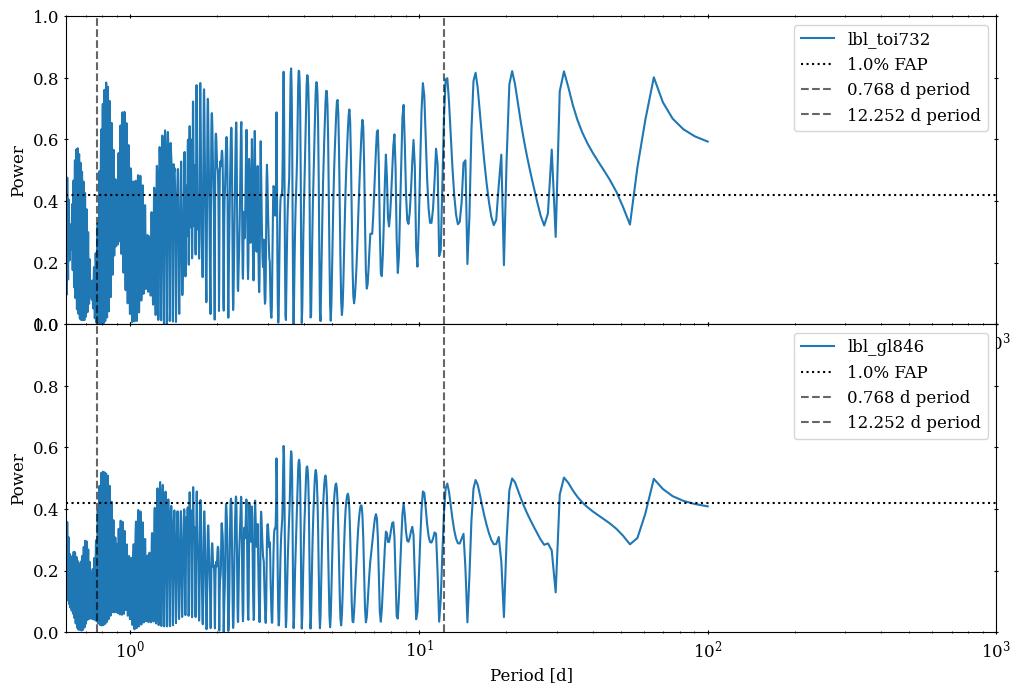

In [14]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 4*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_pub[0].n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_pub[0].n, 3)))
    axes[i].axvline(period_pub[1].n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_pub[1].n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)

# RV fit 

In [15]:
x_ref = dict()
maxrv = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = [np.std(data['vrad'])*2, np.std(data['vrad'])*2]


In [16]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=np.array(period_errs) / np.array(periods), shape=2, testval=np.log(periods),)

        P = pm.Deterministic("P", tt.exp(logP))
        # K = pm.Uniform("K", lower=0, upper=maxrv[k])

        # Wide log-normal prior for semi-amplitude
        #logK = pm.Normal("logK", mu=np.log(maxrv[k]), sd=2.0, shape=2)
        logK = pm.Normal("logK", mu=np.log(Ks_pub), sd=2.0, shape=2, testval=np.log(Ks_pub))
        K = pm.Deterministic("K", tt.exp(logK))

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_pub.n, sd=stmass_pub.s)
        rstar = BoundedNormal("rstar", mu=strad_pub.n, sd=strad_pub.s)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [17]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -266.6215176573096 -> -104.64734166306167
optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -104.64734166306167 -> -104.64734166306167


optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -243.45257516964566 -> -130.95410916203357
optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -130.95410916203357 -> -130.95410916203357


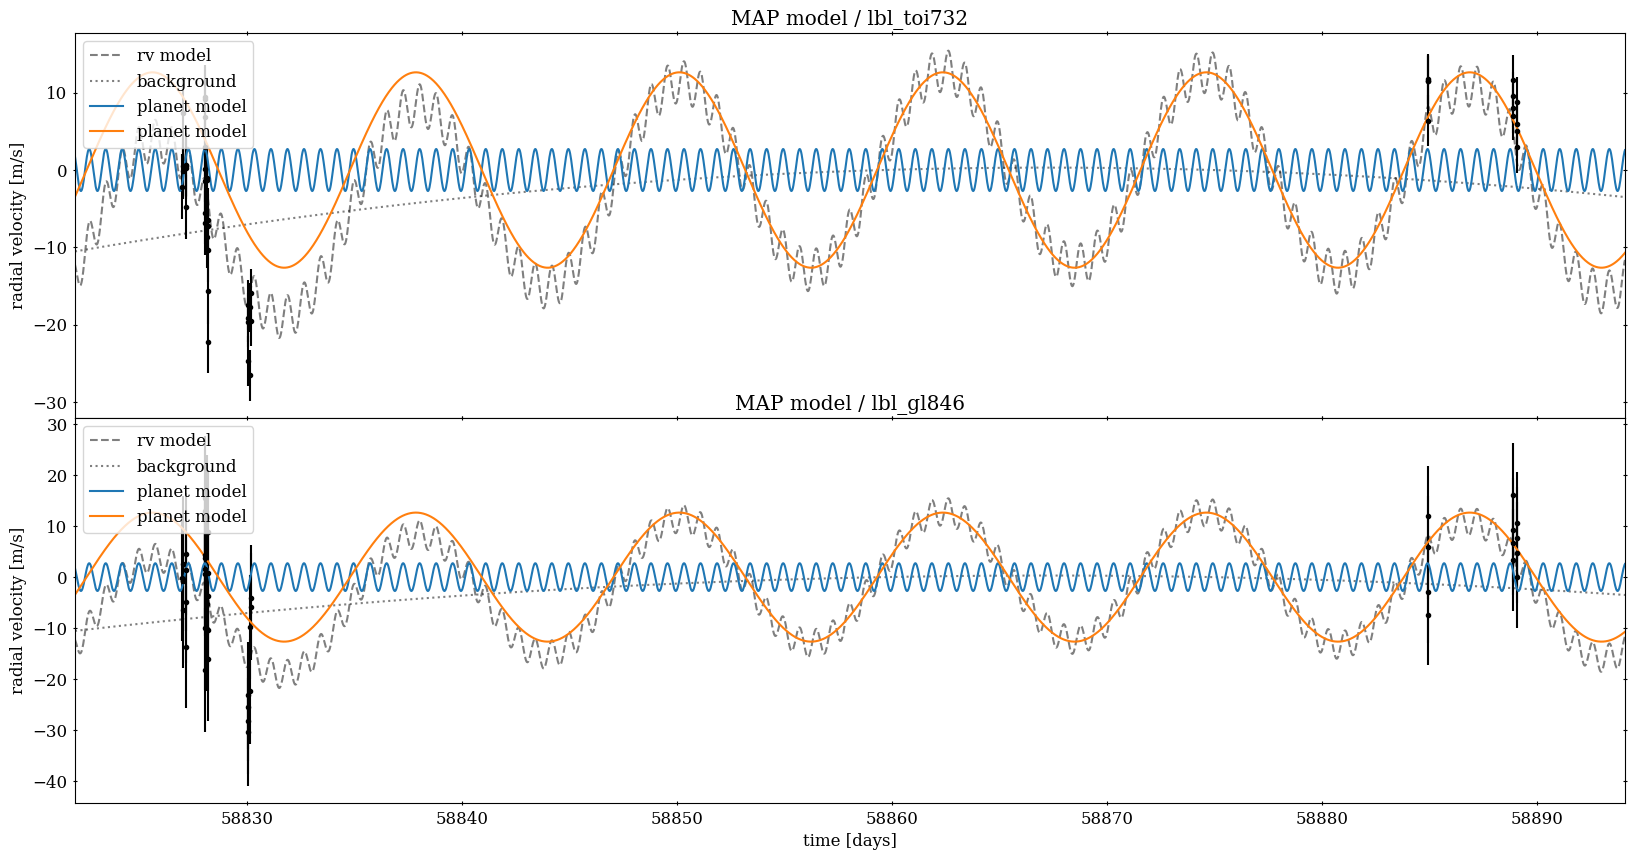

In [18]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [19]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rstar, mstar, trend, logs, logK, logP, t0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rstar, mstar, trend, logs, logK, logP, t0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [20]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


4145.831072888889 2668.1343934444444 1.003346
3440.3643558333333 2474.2534245 1.002151


In [21]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0[0],5.854391e+04,1.097000e-03,5.854391e+04,5.854391e+04,1.600000e-05,1.100000e-05,4631.725677,3134.751091,1.000923,5.854391e+04,1.097000e-03
t0[1],5.854685e+04,1.370000e-03,5.854684e+04,5.854685e+04,2.000000e-05,1.400000e-05,4905.060095,3078.855920,0.999815,5.854685e+04,1.370000e-03
logP[0],-2.634920e-01,1.020000e-04,-2.637650e-01,-2.631620e-01,1.000000e-06,1.000000e-06,4974.219761,3066.900792,1.001027,-2.634940e-01,1.020000e-04
logP[1],2.505729e+00,2.300000e-04,2.505078e+00,2.506409e+00,4.000000e-06,3.000000e-06,4088.460096,3008.178453,1.000483,2.505732e+00,2.300000e-04
P[0],7.683640e-01,7.800000e-05,7.681540e-01,7.686180e-01,1.000000e-06,1.000000e-06,4974.219761,3066.900792,1.001028,7.683620e-01,7.800000e-05
P[1],1.225249e+01,2.815000e-03,1.224452e+01,1.226082e+01,4.400000e-05,3.100000e-05,4088.460096,3008.178453,1.000486,1.225252e+01,2.815000e-03
K[0],2.042925e+00,1.146780e+00,7.463000e-03,5.508075e+00,2.091000e-02,1.478700e-02,2448.447912,1542.172550,1.000478,1.974381e+00,1.146636e+00
K[1],1.561138e+01,1.683672e+00,1.073261e+01,2.150576e+01,2.716000e-02,1.920700e-02,3847.602362,2783.379388,0.999781,1.557592e+01,1.683462e+00
logs,2.789770e-01,2.022968e+00,-1.140325e+01,1.908330e+00,9.578900e-02,6.777700e-02,776.477508,827.201701,1.003346,1.004140e+00,2.022715e+00
trend[0],-5.183000e-03,1.628000e-03,-1.007200e-02,-5.550000e-04,2.400000e-05,1.800000e-05,4520.076807,2663.942343,1.000661,-5.167000e-03,1.628000e-03


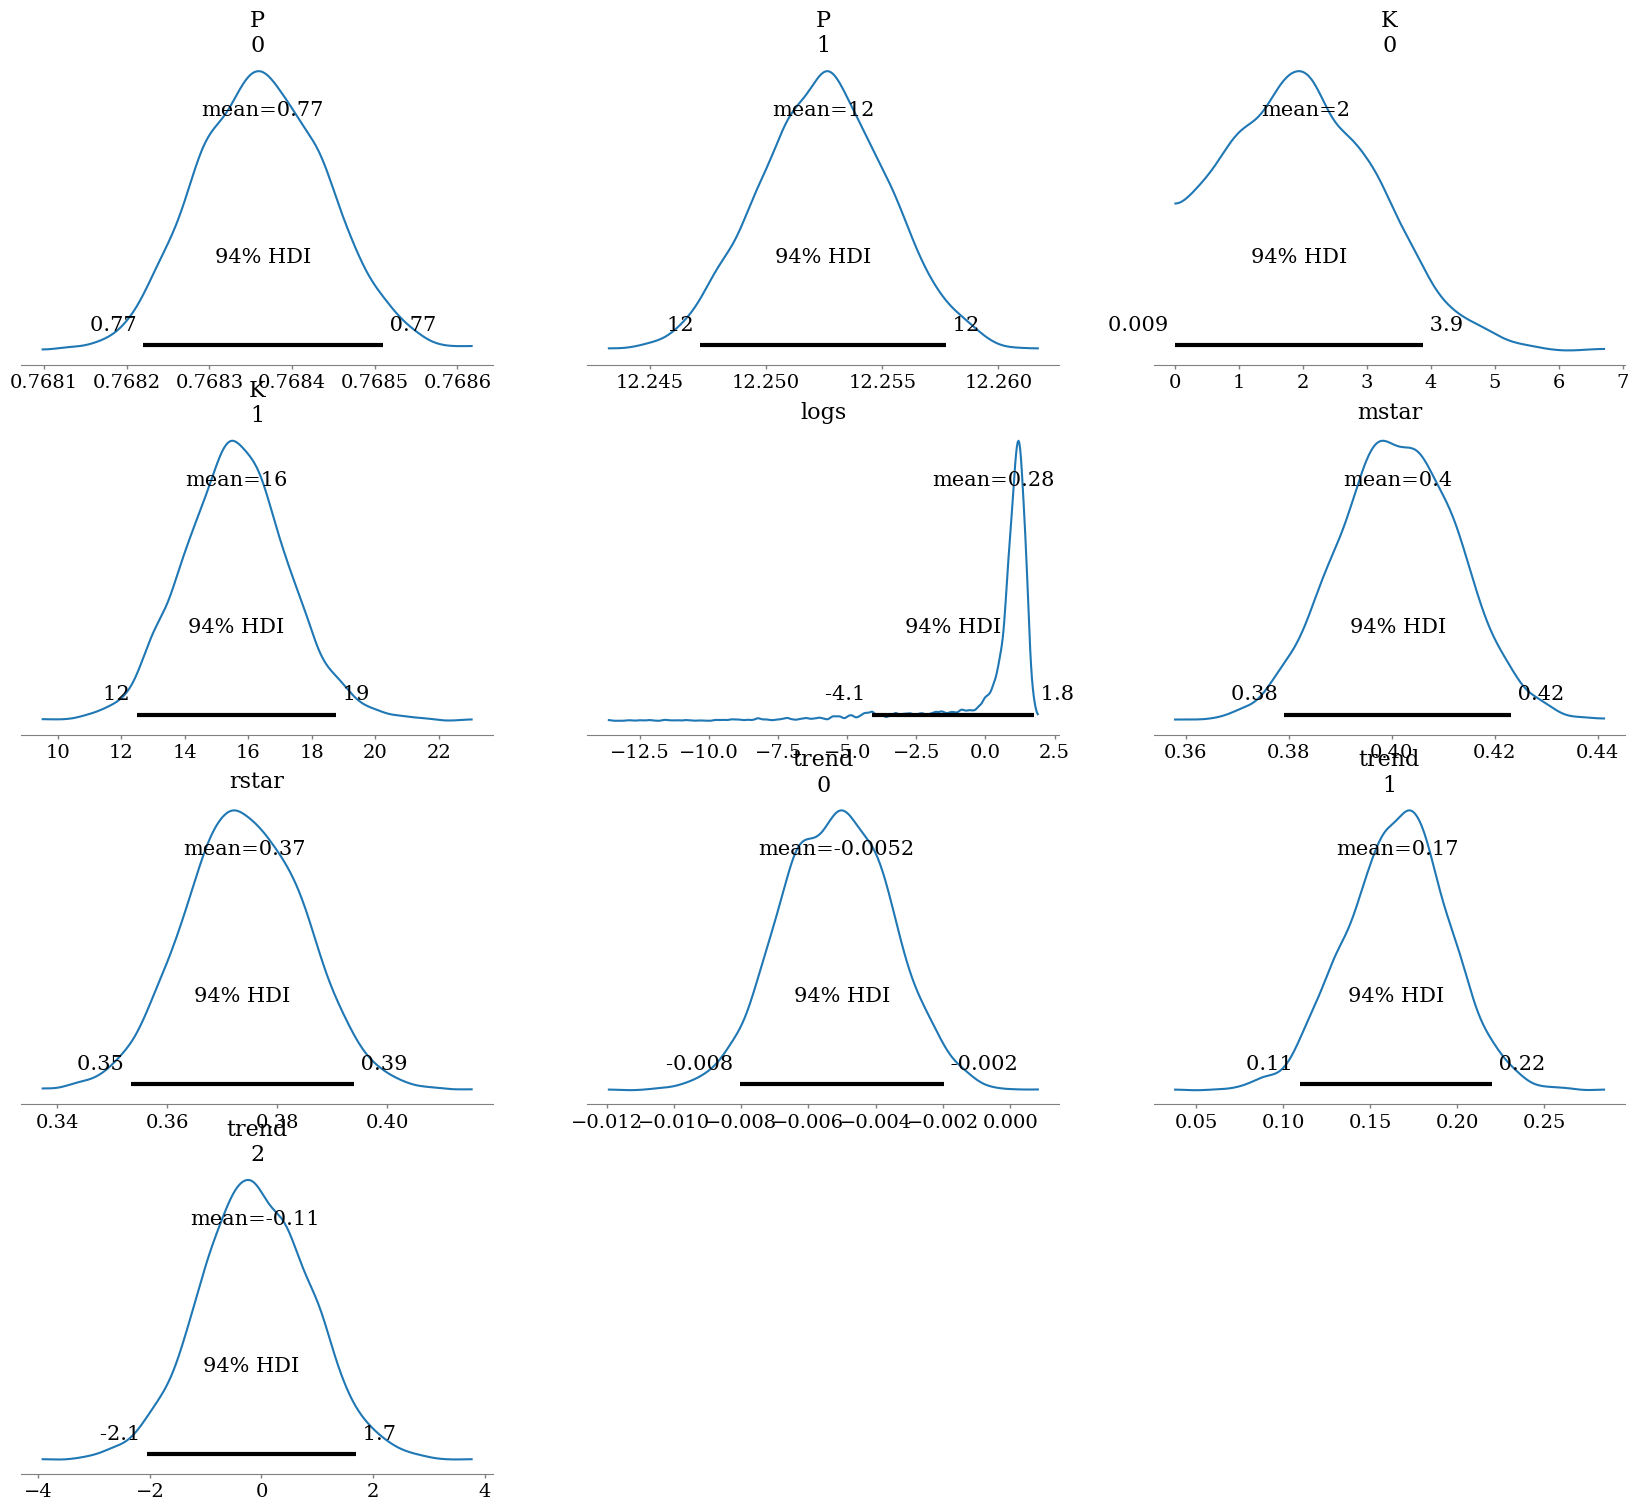

In [22]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [23]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
vrad = dict()
vrad_pred = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = [ufloat(np.median(traces[i].posterior["m_pl"].values[:, :, 0])*u.kg.to(u.M_earth), np.std(traces[i].posterior["m_pl"].values[:, :, 0])*u.kg.to(u.M_earth)),
                ufloat(np.median(traces[i].posterior["m_pl"].values[:, :, 1])*u.kg.to(u.M_earth), np.std(traces[i].posterior["m_pl"].values[:, :, 1])*u.kg.to(u.M_earth))]
    
    K[i] = [ufloat(np.median(traces[i].posterior["K"].values[:, :, 0]), np.std(traces[i].posterior["K"].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior["K"].values[:, :, 1]), np.std(traces[i].posterior["K"].values[:, :, 1]))]
    
    period[i] = [ufloat(np.median(traces[i].posterior["P"].values[:, :, 0]), np.std(traces[i].posterior["P"].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior["P"].values[:, :, 1]), np.std(traces[i].posterior["P"].values[:, :, 1]))]
    
    t_0[i] = [ufloat(np.median(traces[i].posterior['t0'].values[:, :, 0]), np.std(traces[i].posterior['t0'].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior['t0'].values[:, :, 1]), np.std(traces[i].posterior['t0'].values[:, :, 1]))]
    
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())

    smaxis[i] = [ufloat(np.median(traces[i].posterior['a'].values[:, :, 0]), np.std(traces[i].posterior['a'].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior['a'].values[:, :, 1]), np.std(traces[i].posterior['a'].values[:, :, 1]))]

    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))

    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1) 
    vrad[i] = [np.median(traces[i].posterior["vrad"].values[:, :, :, 0], axis=(0, 1)), 
               np.median(traces[i].posterior["vrad"].values[:, :, :, 1], axis=(0, 1))]
    vrad_pred[i] = [traces[i].posterior["vrad_pred"].values[:, :, :, 0], traces[i].posterior["vrad_pred"].values[:, :, :, 1]]

    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)
    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp_b = {mb:.3f} Mearth,       Mp_c = {mc:.3f} Mearth".format(mb=mass[i][0], mc=mass[i][1]))
    print('K_b = {kb:.3f} m/s,             K_c = {kc:.3f} m/s'.format(kb=K[i][0], kc=K[i][1]))
    print("P_b = {pb:.6f} days,      P_c = {pc:.6f} days".format(pb=period[i][0], pc=period[i][1]))
    print("Epoch_b = {eb:.5f},     Epoch_c = {ec:.5f}".format(eb=t_0[i][0], ec=t_0[i][1]))
    print('a_b = {ab:.4f} AU,            a_c = {ac:.4f} AU'.format(ab=smaxis[i][0], ac=smaxis[i][1]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  lbl_toi732
Mp_b = 1.542+/-0.893 Mearth,       Mp_c = 30.600+/-3.343 Mearth
K_b = 1.974+/-1.147 m/s,             K_c = 15.576+/-1.683 m/s
P_b = 0.768362+/-0.000078 days,      P_c = 12.252524+/-0.002815 days
Epoch_b = 58543.91152+/-0.00110,     Epoch_c = 58546.84841+/-0.00137
a_b = 0.0121+/-0.0001 AU,            a_c = 0.0767+/-0.0008 AU
mstar = 0.401+/-0.012 Msun
rstar = 0.374+/-0.011 Rsun
RV jitter =  3+/-6
---------------------------------------------
REDUCTION:  lbl_gl846
Mp_b = 1.241+/-1.429 Mearth,       Mp_c = 22.723+/-8.528 Mearth
K_b = 1.595+/-1.836 m/s,             K_c = 11.576+/-4.340 m/s
P_b = 0.768406+/-0.000085 days,      P_c = 12.252428+/-0.002908 days
Epoch_b = 58543.91152+/-0.00108,     Epoch_c = 58546.84841+/-0.00142
a_b = 0.0121+/-0.0001 AU,            a_c = 0.0767+/-0.0008 AU
mstar = 0.401+/-0.012 Msun
rstar = 0.374+/-0.011 Rsun
RV jitter =  0.1+/-0.4
---------------------------------------------


## Plot results

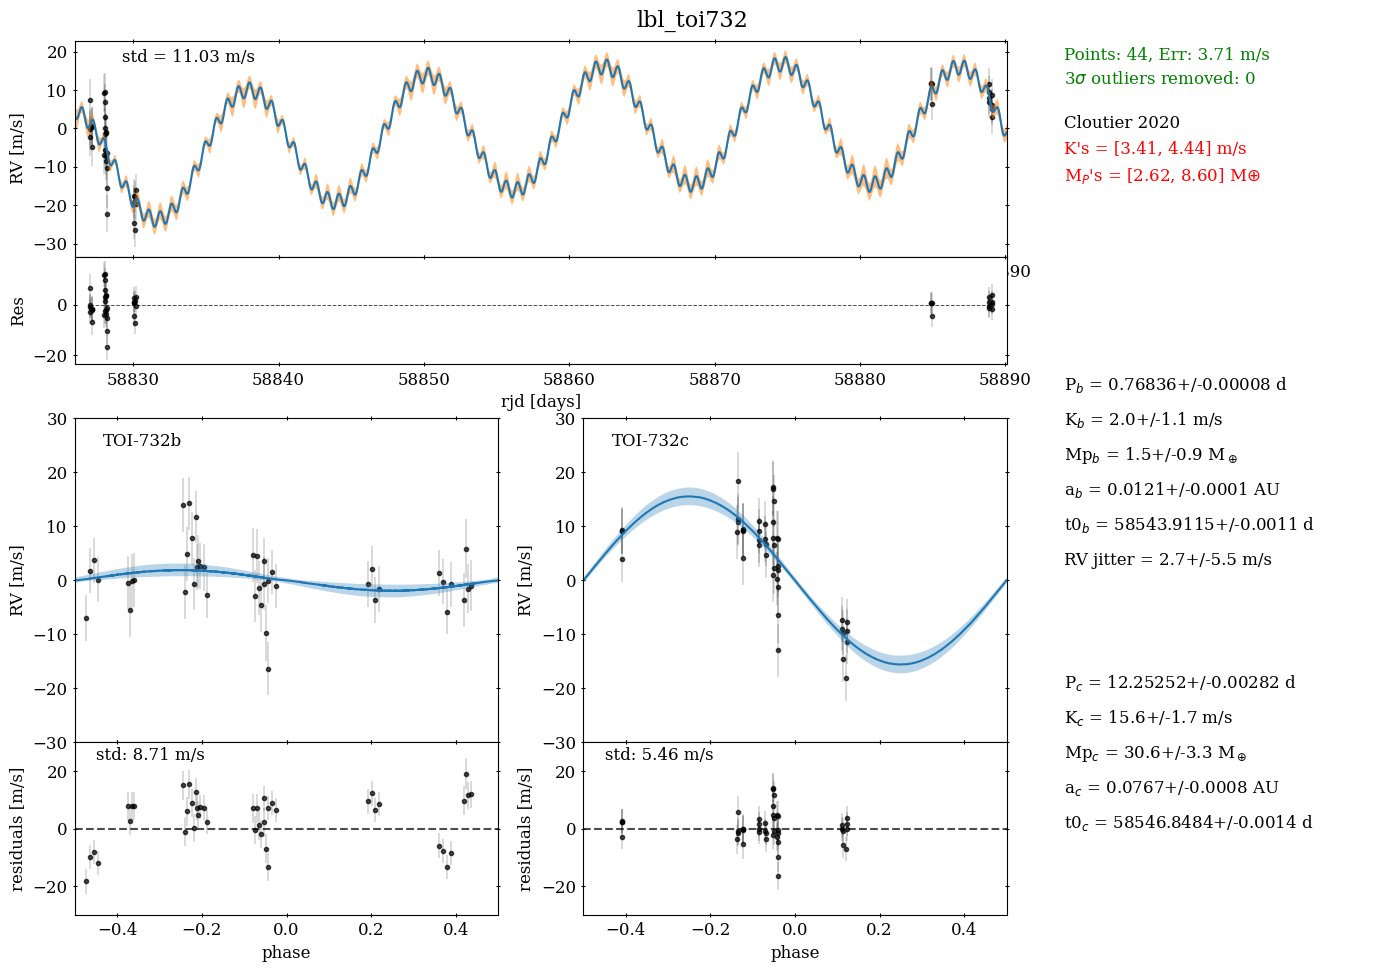

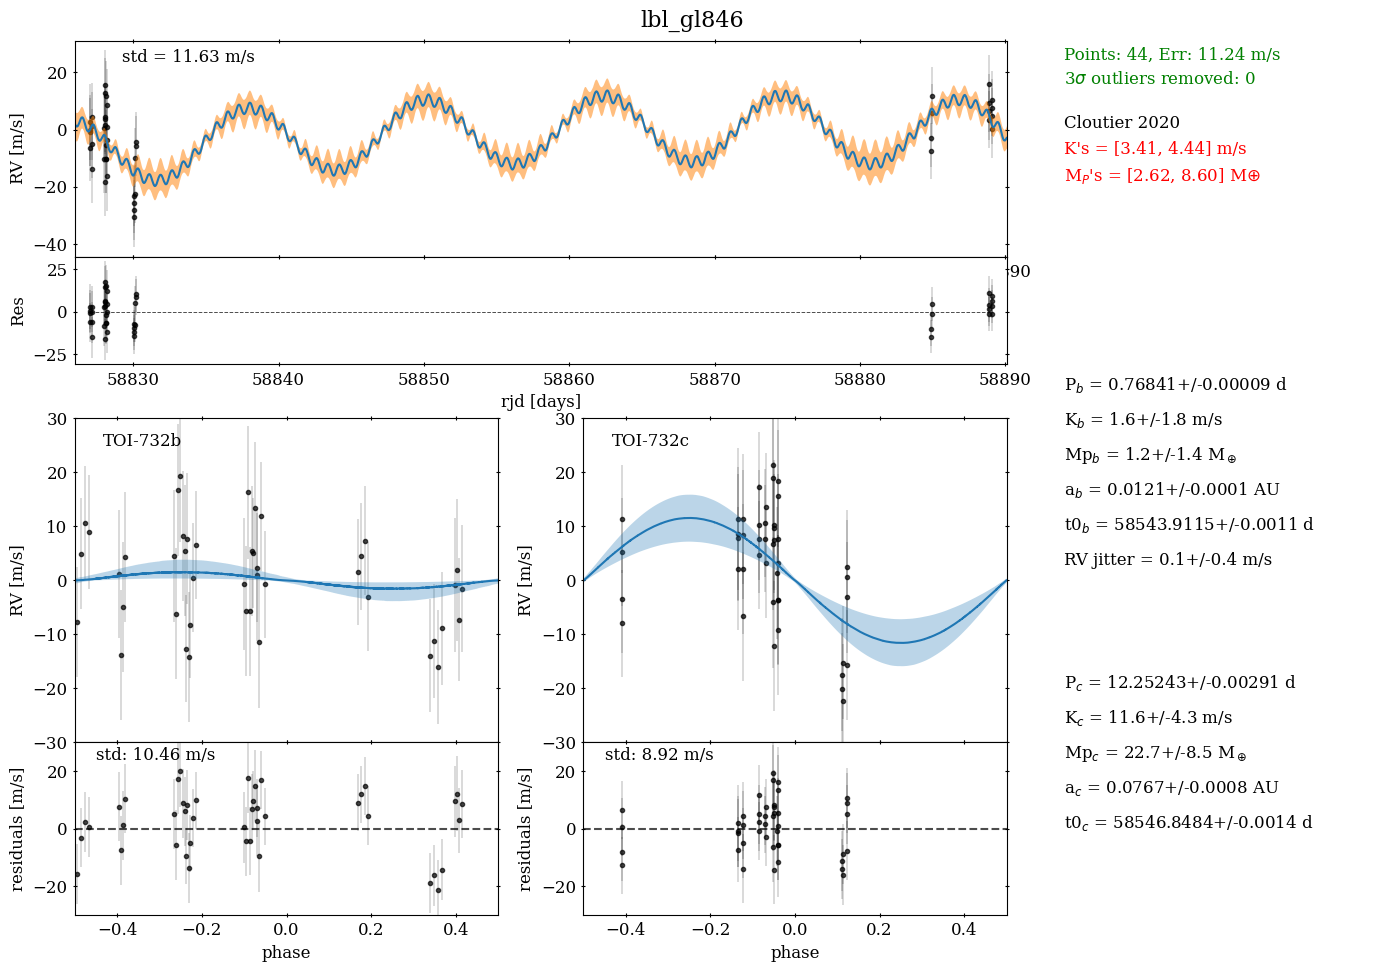

In [24]:
gs_kw = dict(width_ratios=[3, 3, 2], height_ratios=[1, 0.5, 0.25, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplot_mosaic([['0', '0', '5'],
                                  ['00', '00', '5'],
                                  ['11', '11', '5'],
                                  ['1', '2', '5'],
                                  ['3', '4', '5']],
                              gridspec_kw=gs_kw, figsize=(14, 10), layout='tight')
    fig.suptitle(names[k], y=0.97, fontsize=16)

    ax['5'].yaxis.set_visible(False)
    ax['5'].xaxis.set_visible(False)
    ax['5'].spines['left'].set_visible(False)
    ax['5'].spines['bottom'].set_visible(False)
    ax['5'].spines['top'].set_visible(False)
    ax['5'].spines['right'].set_visible(False)

    ax['5'].text(-0.10, 0.978, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax['5'].text(-0.10, 0.95, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax['5'].text(-0.10, 0.90, 'Cloutier 2020', fontsize=12)
    ax['5'].text(-0.10, 0.87, 'K\'s = [{kb:.2f}, {kc:.2f}] m/s'.format(kb=Ks_pub[0], kc=Ks_pub[1]), fontsize=12, color='r')
    ax['5'].text(-0.10, 0.84, 'M$_P$\'s = [{mb:.2f}, {mc:.2f}] M$\oplus$'.format(mb=Ms_pub[0], mc=Ms_pub[1]), fontsize=12, color='r')

    ax['5'].text(-0.10, 0.60, 'P$_b$ = {p:.5f} d'.format(p=period[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.56, 'K$_b$ = {k:.1f} m/s'.format(k=K[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.52, 'Mp$_b$ = {m:.1f} M$_\oplus$'.format(m=mass[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.48, 'a$_b$ = {a:.4f} AU'.format(a=smaxis[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.44, 't0$_b$ = {t:.4f} d'.format(t=t_0[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.40, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)

    ax['5'].text(-0.10, 0.26, 'P$_c$ = {p:.5f} d'.format(p=period[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.22, 'K$_c$ = {k:.1f} m/s'.format(k=K[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.18, 'Mp$_c$ = {m:.1f} M$_\oplus$'.format(m=mass[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.14, 'a$_c$ = {a:.4f} AU'.format(a=smaxis[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.10, 't0$_c$ = {t:.4f} d'.format(t=t_0[k][1]), fontsize=12)

    # plot the RVs and the model in the first subplot
    ax['0'].errorbar(data['rjd'], data['vrad'], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax['0'].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax['0'].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax['0'].set_ylabel("RV [m/s]")
    ax['0'].set_xlabel("rjd [days]")
    # add initial dispersion
    ax['0'].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax['0'].transAxes)
    ax['0'].sharex(ax['00'])
    # add the residuals in the second subplot
    ax['00'].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax['00'].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax['00'].set_xlim(data['rjd'].min()-1, data['rjd'].max()+1)
    ax['00'].set_xlabel("rjd [days]")
    ax['00'].set_ylabel("Res")

    # delete the third subplot so it shows as a gap
    ax['11'].set_visible(False)
    # plot the folded data in the second row
    for i, letter in enumerate('bc'):
        x_fold = (data['rjd'] - t_0[k][i].n + 0.5 * period[k][i].n) % period[k][i].n - 0.5 * period[k][i].n
        ax[str(i+1)].errorbar(x_fold/period[k][i].n, data['vrad']-bkg_[k]-vrad[k][(i + 1) % 2], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k",
                    markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
        ax[str(i+1)].set_ylabel("RV [m/s]")
        ax[str(i+1)].set_xlabel("phase")
        ax[str(i+1)].set_xlim(-0.5, 0.5)
        ax[str(i+1)].set_ylim(-30, 30)
    
        # Compute the posterior prediction for the folded RV model for this planet
        t_fold = (t[k] - t_0[k][i].n + 0.5 * period[k][i].n) % period[k][i].n - 0.5 * period[k][i].n
        inds = np.argsort(t_fold)
        pred = np.percentile(traces[k].posterior["vrad_pred"].values[:, :, inds, i], [16, 50, 84], axis=(0, 1))
        ax[str(i+1)].plot(t_fold[inds]/period[k][i].n, pred[1], color="C0", label="TOI-732"+letter)
        art = ax[str(i+1)].fill_between(t_fold[inds]/period[k][i].n, pred[0], pred[2], color="C0", alpha=0.3)
        art.set_edgecolor("none")
        ax[str(i+1)].legend(fontsize=12, loc='upper left', frameon=False, handlelength=0)

        # Compute the residuals for both planets
        ax[str(i+3)].errorbar(x_fold/period[k][i].n, data['vrad']-bkg_[k]-vrad[k][i]-vrad[k][0]*((i + 1) % 2), yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k",
                    markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
        ax[str(i+3)].hlines(0, -0.5, 0.5, color='k', linestyle='--', alpha=0.7)
        ax[str(i+3)].set_ylabel("residuals [m/s]")
        ax[str(i+3)].set_xlabel("phase")
        ax[str(i+3)].set_xlim(-0.5, 0.5)
        ax[str(i+3)].set_ylim(-30, 30)
        # plot inside the two plots the value of the dispersion of the residuals
        ax[str(i+3)].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-bkg_[k]-vrad[k][i]-vrad[k][0]*((i + 1) % 2)), 2))+' m/s', transform=ax[str(i+3)].transAxes)

    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')